# Lab One: Exploring Table Data
Team: Jack Babcock, Hayden Center, Fidelia Navar, Amory Weinzierl

### Assignment Description
You are to perform preprocessing and exploratory analysis of a data set: exploring the statistical summaries of the features, visualizing the attributes, and addressing data quality. This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output.

Additional information and requirements can be found at https://smu.instructure.com/courses/81978/assignments/465788

## Part I -  Business Understanding

The data set (which can be found at https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) that we have chosen to utilize for this lab consists of data that may be used to identify whether or not an individual is at risk for strokes.<br><br>
This data was likely collected by medical professionals in a medical trial with the goal of recognizing what attributes may contribute to the likelihood of a stroke in an individual. We may speculate that this was the given circumstances the data was collected under (although not explicitly said) because medical records are not publicly available and, thus, the patients involved would have had to have been aware that the data would be used for a study. Further, we can safely assume that the data was collected by medical professionals because they know what sort of attributes would be pertinent to increasing the chance of a stroke and it is in their interest to conduct studies of this sort to further their knowledge about such medical happenings.<br><br>
Given the attributes of the individuals involved in this dataset, ideally it would be possible to predict whether an individual is at heightened risk for strokes. This functionality would be valuable to third parties in the medical industry; an accurate diagnoses done with training and classification may remove the possibility of human error in false diagnoses or lack of diagnoses. Furthermore, I think this functionality may also be useful to general users; of course, an app should never replace a medical professional but, if an individual is health-conscious and deemed at high risk for strokes, an app may be helpful to keep track of changing statistics on an individual basis and how that may affect an individual's risk of stroke. For example, if an individual's BMI decreases or increases, an individual may put that change into the app and see how that may affect their risk.<br><br>
Quite simply, our prediction algorithm would need to perform better than its competitors. Performing better may be defined as less false positives and negatives. According to "Positive predictive value of stroke identification by ambulance clinicians in North East England: a service evaluation," 38% of diagnosed strokes between June 2013 and May 2016 were false positives. In 2012, the Dijon Stroke Registry identified 811 patients with a stroke, among who 186 were considered false-negatives. Further, of the 903 patients discharged following a stroke, 278 were found to be false positives (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566387/). As given in the preceding data, 23% of diagnosed strokes were false negatives and 31% of diagnosed strokes were false positives. Thus, our algorithm must be more accurate than the calculated percentage of false negatives and false positives to be considered more useful than at least human diagnoses. In terms of performing better than competing instruments, our algorithm must report better than 85% - 90% sensitivity (https://pubmed.ncbi.nlm.nih.gov/17678494/).<br><br>
Additional details to consider and implement in our algorithm may be characteristics of common misdiagnoses. According to the article "Stroke misdiagnosis -- why does it still happen," the misdiognosis of strokes is the most common medical negligence issue encountered by the sponsor of the article (https://www.browells.co.uk/stroke-misdiagnosis-still-happen/). For example, in younger patients, strokes are commonly misdiagnosed as false negatives where it is thought that the issue is veritgo or alcohol intoxication (https://journals.lww.com/neurotodayonline/fulltext/2009/04020/younger_stroke_patients_often_misdiagnosed.8.aspx). Thus, our algorithm must address these common misdiagnosis. It may do so by factoring in extra information to report if an individual is at high risk for misdiagnoses.

## Part II - Data Understanding

### Data Description

#### Importing

In [2]:
import numpy as np
import pandas as pd

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)

df = pd.read_csv('healthcare-dataset-stroke-data.csv')

df.head()

Pandas: 1.1.0
Numpy: 1.20.1


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Formatting

To clean up the data a little bit, we're going to normalize the values of the non-numeric columns to have the same format by setting all values to lowercase and replacing spaces with underscores.

In [3]:
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].str.lower()
        
df = df.replace(' ', '_', regex=True)
        
for c in df.columns:
    if df[c].dtype == 'object':
        print(df[c].unique())

['male' 'female' 'other']
['yes' 'no']
['private' 'self-employed' 'govt_job' 'children' 'never_worked']
['urban' 'rural']
['formerly_smoked' 'never_smoked' 'smokes' 'unknown']


All of the columns look good except for the smoking_status column. One of the values in that column is listed as 'unknown'. Though this is technically a value, what it is actually representing is missing information, so let's make that more clear.

In [4]:
df.smoking_status.mask(df.smoking_status == 'unknown', pd.NA, inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     3566 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


Some of the categorical columns should be converted into numerical columns. Specifically the ever_married column should be converted into a binary column similar to the hypertension, heart_disease, and stroke columns, and the smoking_status column should be converted into an ordinal. We think this is a meaningful change because there is a very clear way to assign an order to the values: never_smoked is 0, formerly_smoked is 1 since it is worse for your health, and finally smokes is 2, since it is worse than formerly_smoked.

In [5]:
df.smoking_status.replace(to_replace= ['never_smoked', 'formerly_smoked', 'smokes'], value = [0, 1, 2], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     3566 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Data Quality

#### Duplicate Values

The first thing we'll want to do to check the quality of the data is to check for duplicates. First, let's make sure there are no duplicate IDs in the dataset.

In [6]:
if df.id.unique().size == df.id.size:
    print("No duplicate IDs")

No duplicate IDs


Now that we know there are no duplicate IDs, let's check if there are any rows with identical values (excluding the ID).

In [7]:
cols = df.columns.drop('id')

s = df.duplicated(subset=cols, keep='first')

s[s]

Series([], dtype: bool)

Seems like the dataset has no exact duplicates. We feel safe assuming that, finding no exact duplicates, each entry in the dataset is unique.

#### Missing Values

The second thing to check the dataset for is missing values. We can see them by checking df.info().

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     3566 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Now we can see how much data is really missing from this dataset. We have over 1500 missing datapoints from the smoking_status column. Now let's take a look at both of the columns with missing data and see if we want to impute or delete them.

In [9]:
from sklearn.impute import KNNImputer
import copy

knn = KNNImputer(n_neighbors=3)

temp = df[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'bmi',
    'stroke'
]].to_numpy()

temp_imputed = knn.fit_transform(temp)

df_imputed = copy.deepcopy(df)
df_imputed[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'bmi',
    'stroke'
]] = temp_imputed
# df_imputed.info()

df_imputed.bmi = df_imputed.bmi.apply(lambda x: round(x, 1))

print(df_imputed.count())

id                   5110
gender               5110
age                  5110
hypertension         5110
heart_disease        5110
ever_married         5110
work_type            5110
residence_type       5110
avg_glucose_level    5110
bmi                  5110
smoking_status       3566
stroke               5110
dtype: int64


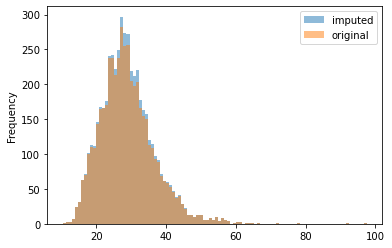

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

df_imputed.bmi.plot(kind='hist', alpha=0.5, label="imputed",bins=100)
df.bmi.plot(kind='hist', alpha=0.5, label="original",bins=100)
plt.legend()
plt.show()

## Part III - Data Visualization

hypertension             False      True 
gender ever_married                      
female no            96.777442   3.222558
       yes           87.806097  12.193903
male   no            97.247706   2.752294
       yes           85.133136  14.866864

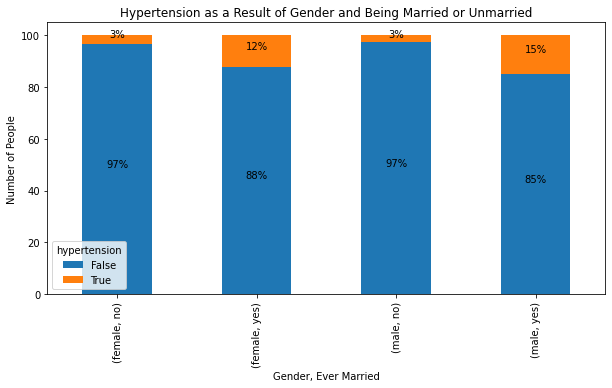

heart_disease            False      True 
gender ever_married                      
female no            98.288016   1.711984
       yes           95.202399   4.797601
male   no            98.034076   1.965924
       yes           89.053254  10.946746

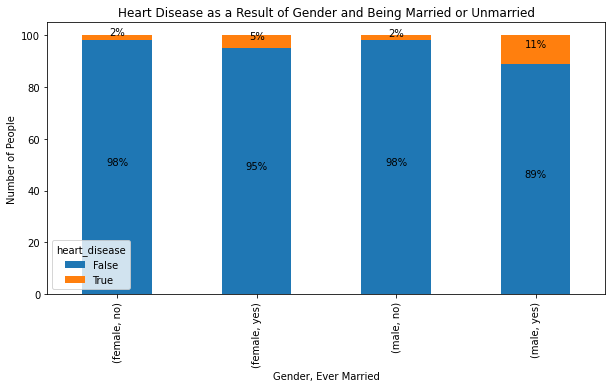

stroke                   False     True 
gender ever_married                     
female no            97.885196  2.114804
       yes           94.002999  5.997001
male   no            98.951507  1.048493
       yes           92.603550  7.396450

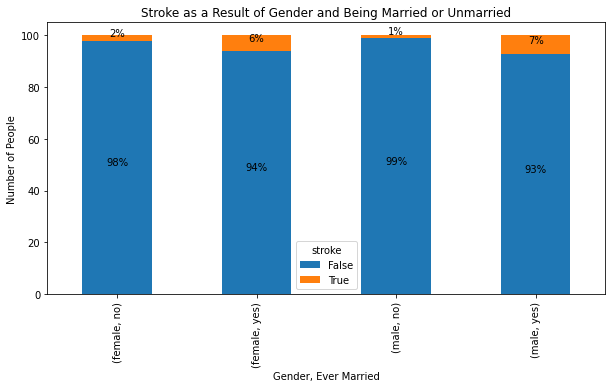

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

df_imputed.drop(df_imputed[df_imputed.gender == 'other'].index, inplace=True)

hyper = pd.crosstab([df_imputed['gender'], df_imputed['ever_married']], df_imputed.hypertension.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
hyper_ = hyper.plot.bar(figsize=(10,5),stacked=True)
display(hyper)

for rec in hyper_.patches:
    height = rec.get_height()
    hyper_.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.title('Hypertension as a Result of Gender and Being Married or Unmarried')
plt.xlabel('Gender, Ever Married')
plt.ylabel('Number of People')
plt.show()

heart= pd.crosstab([df_imputed['gender'], df_imputed['ever_married']], df_imputed.heart_disease.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
heart_ = heart.plot.bar(figsize=(10,5),stacked=True)
display(heart)

for rec in heart_.patches:
    height = rec.get_height()
    heart_.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.title('Heart Disease as a Result of Gender and Being Married or Unmarried')
plt.xlabel('Gender, Ever Married')
plt.ylabel('Number of People')
plt.show()

gender = pd.crosstab([df_imputed['gender'], df_imputed['ever_married']], df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
gender_ = gender.plot.bar(figsize=(10,5),stacked=True)
display(gender)

for rec in gender_.patches:
    height = rec.get_height()
    gender_.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.title('Stroke as a Result of Gender and Being Married or Unmarried')
plt.xlabel('Gender, Ever Married')
plt.ylabel('Number of People')
plt.show()

The above visuals exemplify the presence of hypertension, heart disease, and strokes in married and unmarried individuals of the genders male and female. We felt this would be an interesting and slightly comedic correlation to explore and the results actually confirm our hypothesis that married individuals would report to have higher levels of hypertension, heart disease, and risk for stroke. Overall, however, most of the data explored in the above visuals of the relationship between married and unmarried indviduals and hypertension, heart disease, and stroke supports that there is very little correlation, as there is overwhelmingly little overlap between being married and suffering from hypertension, heart disease, and stroke. However, in the cases where individuals report to suffer from one or more of the three, the percentages reflect that married individuals reported higher rate of suffering from hypertension, heart disease, and stroke than the unmarried individuals. So, while there is not strong correlation, it is interesting to see these higher rates in the married individuals.  

## Explanation and Question for Hayden's Visual
<b>Question 3: Based on the data presented in the dataset, what are the most prevalent attributes that indicate an individual's likelihood of stroke?</b>

Description:<br>
Building upon the two previous visuals, we utilized the visual above to explore which attribute(s) have the highest conditional probability of indicating risk of stroke. According to the visual above, heart disease reflects the most correlation to indication of stroke. Next is hypertension and then being elderly. Heart disease reflects over a 0.16 conditional and the probabilities for both hypertension and being elderly are between 0.12 and 0.14. It is important to note that, after these three attributes, the probability of the remaining attributes is significantly lower. The next ranked attribute -- self-employed -- reflects a probability of aruond 0.08. This is interesting because it presents very clearly three attributes with high probability to be directly correlated to creating or contributing to risk of stroke is having heart disease, hypertension, and being eldery. Therefore, it is logical to assume that a combination of these three attributes in an individual could indicate a high probability of stroke.<br>
Something about this visual that I found interesting was that having a normal bmi was more likely to indicate the likelihood of a stroke, with a probability of approximately 0.7, than having a high bmi, which had a probability of less than 0.06.

## Part IV - Exceptional Work

## Explanation of UMap Results
The clusters reported in the resulting UMAP from our dataset represent the datapoints projected onto a 2-dimensional plane. The reduced components used to represent and group these datapoints are by whether the individual has hypertension, heart disease, stroke, the individual's gender, whether they have ever been married, their smoking status, their bmi, their average glucose level, and their age. The UMAP is colored according to whether the individual is considered healthy, whether they have had a stroke, heart disease, hypertension, or any combination of the three. We used this system to color the UMAP because, after some trial and error, it was found that using this system most clearly represented the data in the clusters; using this system also allowed us to focus on what we considered to be the most significant attributes. Thus, we see clusters represented by the same reduced component very close together on the UMAP. However, we see combinations of these components, like hypertension and heart disease, plotted farther away from one of the parent components, like hypertension, than would be hypothesized. This distance is explained by the other attributes stored in each datapoint; individuals with both hypertension and heart disease have more similar remaining attributes than individuals with just hypertension.<br>
Something interesting presented by the UMAP is the clustering of datapoints with stroke and heart disease and the datapoints with all three (stroke, heart disease, and hypertension); the clusters of these datapoints overlap completely. We can therefore conclude that, if an individual has both stroke and heart disease, they very likely also have hypertension.